Classification Using ResNet

https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5

let's not reinvent the wheel over here

0. Setup deep learning environment

In [2]:
import os
import pandas as pd
import pathlib
from pathlib import Path

import torch
from torchvision import models

In [3]:
# Check version of Pytorch
print(torch. __version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

2.6.0+cu124
cuda
True


## Step 1: Load the pretrained model

In [4]:
#Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained = True)

/home/ascott10/micromamba/envs/caps/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ascott10/micromamba/envs/caps/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)




## Step 2: Freeze the pretrained layers

#Only train the last few layers for our specific task
#Prevents weights of pre-trained layers from being updated during training

In [5]:

#Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False



## Step 3: Modify the last layer
#The last layer is a fully connected layer that outputs a 1000-dim vector
#Need to modify to output the # of classes in our dataset

In [6]:
#Modify the last layer of the model
num_classes = 2 #replace with number of classes in dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

## Step 4: Load the custom dataset

In [7]:
#input folder paths
input_path_mut = '/home/ascott10/documents/school/capstone/mutant'
input_path_wt = '/home/ascott10/documents/school/capstone/wt'

#Retrieve files
image_filepaths_mut = []
image_mut_labels = []
image_mut_id = []
image_filepaths_wt = []
image_wt_labels = []
image_wt_id = []


#for each file in the inputs add path to storage list:

for files in os.listdir(input_path_mut):
    if files.endswith('png'):
        image_filepaths_mut.append(os.path.join(input_path_mut,files))
        image_mut_labels.append('mutant')
        image_mut_id.append(Path(files).parts[-1][:-4])

for files in os.listdir(input_path_wt):
    if files.endswith('png'):
        image_filepaths_wt.append(os.path.join(input_path_wt,files))
        image_wt_labels.append('wt')
        image_wt_id.append(Path(files).parts[-1][:-4])

mutant_df = pd.DataFrame([image_filepaths_mut, image_mut_labels, image_mut_id], index= ['file_path', 'class', 'im_id']).T

wt_df = pd.DataFrame([image_filepaths_wt, image_wt_labels, image_wt_id], index= ['file_path', 'class', 'im_id']).T

wt_df

all_files_df = pd.concat([mutant_df, wt_df], ignore_index=True)

all_files_df

,file_path,class,im_id
0,/home/ascott10/documents/school/capstone/mutan...,mutant,A2_MHV_AxA_0005_Ceta_578_912
1,/home/ascott10/documents/school/capstone/mutan...,mutant,A2_MHV_AxA_0021_Ceta_2087_954
2,/home/ascott10/documents/school/capstone/mutan...,mutant,A2_MHV_AxA_0082_Ceta_3176_566
3,/home/ascott10/documents/school/capstone/mutan...,mutant,A2_MHV_AxA_0058_Ceta_3477_1554
4,/home/ascott10/documents/school/capstone/mutan...,mutant,A2_MHV_AxA_0085_Ceta_1241_3163
...,...,...,...
924,/home/ascott10/documents/school/capstone/wt/MH...,wt,MHVWT_A70021_879_399
925,/home/ascott10/documents/school/capstone/wt/MH...,wt,MHVWT_A70053_2141_2078
926,/home/ascott10/documents/school/capstone/wt/MH...,wt,MHVWT_A70020_2528_277
927,/home/ascott10/documents/school/capstone/wt/MH...,wt,MHVWT_A70036_3386_1367


In [8]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df = train_test_split(all_files_df,test_size = 0.2)
X_train_df, X_val_df = train_test_split(X_train_df,test_size = 0.25)

In [9]:
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import cv2

#Define the transformations to apply to the images


# Define transformations (for PyTorch)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

#Function to process df to tensors

def create_tensor_dataset(df):
    images = []
    labels = []

    for _, row in df.iterrows():
        #for file_path, class
        file_path, label = row[0], row[1]

        #open the image and convert
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256,256))

        img = transform(img) #Apply Pytorch transforms

        images.append(img)
        labels.append(int(1) if label == 'mutant' else int(0)) #convert labels to ints

    #lists to tensorts
    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels, dtype = torch.long)

    return TensorDataset(images_tensor, labels_tensor)




In [10]:
#Create datasets
train_dataset = create_tensor_dataset(X_train_df)
val_dataset = create_tensor_dataset(X_val_df)
test_dataset = create_tensor_dataset(X_test_df)

#Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

/tmp/ipykernel_3097/539256888.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file_path, label = row[0], row[1]



## Step 5: Define the loss function and optimizer

In [11]:


#Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(),
                             lr = 0.001)
                             


#Use Pytorch DataLoader and TrainLoader utilities

#Create Data Loaders for the train and validation datasets

## Step 6: Train the model

In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

## Step 7: Fine-tune the model on the custom dataset
Train the last layer for a few epochs, then unfreeze all layers and train the entire network for a few more epochs

In [13]:
#Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#Fine tune the last layer for a few epochs
optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.01)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], train loss: 0.8480, train acc: 0.7325, val loss: 0.5585, val acc: 0.7097
Epoch [2/5], train loss: 0.3576, train acc: 0.8528, val loss: 0.5871, val acc: 0.7312
Epoch [3/5], train loss: 0.2463, train acc: 0.9066, val loss: 1.2713, val acc: 0.6022
Epoch [4/5], train loss: 0.3393, train acc: 0.8671, val loss: 0.3359, val acc: 0.8495
Epoch [5/5], train loss: 0.1753, train acc: 0.9210, val loss: 0.2219, val acc: 0.9355


In [14]:
#Freeze all layers and fine tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], train loss: 0.7365, train acc: 0.8582, val loss: 15.8195, val acc: 0.5645
Epoch [2/10], train loss: 0.1574, train acc: 0.9533, val loss: 0.7265, val acc: 0.8602
Epoch [3/10], train loss: 0.0730, train acc: 0.9749, val loss: 0.1267, val acc: 0.9624
Epoch [4/10], train loss: 0.0127, train acc: 0.9982, val loss: 0.1032, val acc: 0.9516
Epoch [5/10], train loss: 0.0087, train acc: 0.9964, val loss: 0.1382, val acc: 0.9570
Epoch [6/10], train loss: 0.0457, train acc: 0.9820, val loss: 0.1330, val acc: 0.9409
Epoch [7/10], train loss: 0.1146, train acc: 0.9623, val loss: 0.4463, val acc: 0.9140
Epoch [8/10], train loss: 0.0496, train acc: 0.9803, val loss: 0.8140, val acc: 0.8387
Epoch [9/10], train loss: 0.0078, train acc: 0.9964, val loss: 0.1017, val acc: 0.9570
Epoch [10/10], train loss: 0.0053, train acc: 0.9982, val loss: 0.3904, val acc: 0.9194


In [15]:
torch.save(model.state_dict(), "resnet_weights.pth")

# Load Model 

In [16]:
# Reinitialize
model = models.resnet18(pretrained = False) #loading custom weights

#Modify the last layer
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features,2)

#Load trained weights
model.load_state_dict(torch.load('resnet_weights.pth'))
model.eval()

/home/ascott10/micromamba/envs/caps/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ascott10/micromamba/envs/caps/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
#To GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Make Predictions

In [18]:
import torch
from sklearn.metrics import confusion_matrix

predictions = []
correct = 0  # Initialize correct count
total = 0    # Initialize total count

with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to same device as model
        
        outputs = model(images)  
        _, predicted = torch.max(outputs, 1)  

        predictions.extend(predicted.tolist())  # Store predictions
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate Accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Copy test dataframe
X_test_df_preds = X_test_df.copy()

# Assign predicted labels
X_test_df_preds["predicted_label"] = ["mutant" if p == 1 else "wt" for p in predictions]

# Print Confusion Matrix
print(f"Confusion Matrix: \n {confusion_matrix(X_test_df_preds['class'], X_test_df_preds['predicted_label'])}")

# Drop file_path column
X_test_df_preds = X_test_df_preds.drop('file_path', axis=1)

# Get the confusion matrix
cf_matrix = confusion_matrix(X_test_df_preds['class'], X_test_df_preds['predicted_label'])


Test Accuracy: 95.16%
Confusion Matrix: 
 [[94  9]
 [ 0 83]]


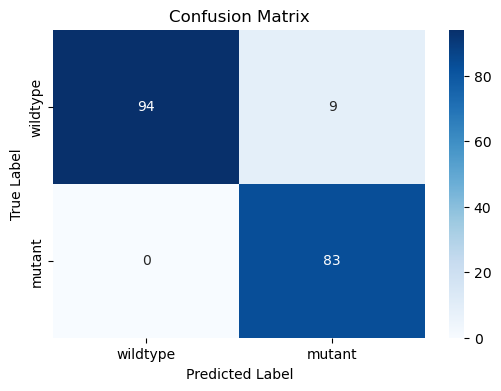

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
labels = ["wildtype", "mutant"]

# Create heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show plot
plt.show()